# Livrable final du projet - Projet Green Graph
*Equipe CesiCDP - Chef de projet : Leila | Opérateurs : Tom, Edwin*</br>
## Sommaire :
    1. Introduction

    PARTIE 1 : Modélisation
    2. Rappel de la modélisation formelle
        2.1. Résumé des hypothèses et représentations
        2.2. Justification du maintien de la modélisation
    3. Méthodes de résolution
        3.1. Choix des algorithmes
        3.2. Description des algorithmes 
        3.3. Complexité des algorithmes 

    PARTIE 2 : Implémentation et exploitation
    4. Implémentation
        4.1. Détails de l’implémentation des algorithmes
        4.2. Cas de test représentatifs
        4.3. Résultats observés sur les tests
    5. Étude expérimentale
        5.1. Méthodologie du plan d’expérience
        5.2. Analyse des performances 
        5.3. Limites observées
        5.4. Perspectives d’amélioration

    6. Plan de Travail et Organisation du Projet
        6.1. Étapes prévues 

    7. Conclusion

    8. Annexes
        8.1. Glossaire
        8.2. Références bibliographiques
        8.3. Annexes techniques 

### 1. Introduction
Dans la continuité de notre premier livrable, ce document final a pour objectif de présenter l'ensemble de la démarche menée autour du projet Green Graph, de la modélisation initiale à l'évaluation expérimentale des solutions implémentées.

Pour rappel, on se questionnait sur comment réduire l’impact environnemental des tournées de livraison tout en optimisant les coûts opérationnels.<br>
En modélisant ce problème à partir du **Problème du Voyageur de Commerce (PVC)** complété avec des contraintes réalistes :
* **Coût ou restriction de passage sur certaines arêtes :** Certaines routes peuvent être plus coûteuses ou interdites,
* **Dépendances entre visites :** Une ville ne peut être visitée qu'après en avoir visité une autre,

nous avons pu définir une approche formelle qui répond aux besoins de planification d'un trajet routier réel.

La première partie du projet consiste à modéliser mathématiquement le problème, nous y détaillons également les méthodes de résolution sélectionnées, en mettant en lumière les raisons de nos choix algorithmiques, ainsi que la complexité associée.

La seconde partie est dédiée à la mise en œuvre : l’implémentation des algorithmes, les cas de test choisis, et l’analyse des résultats obtenus. Cette étude expérimentale permet d'évaluer la performance des solutions proposées, leurs limitations, et d’ouvrir la voie à de nouvelles perspectives d’amélioration.


## Partie 1
### 2. Rappel de la modélisation formelle
##### 2.1. Résumé des hypothèses et représentations
Pour rappel, notre réseau routié est représenté sous la forme d'un graphe  non orienté $G = (V, E)$, où :
* $V = {v_0, v_1, ..., v_n}$ représente les sommets (le dépôt $v_0$ et les points de livraison),
* $E$ l’ensemble des arêtes, représentant les routes entre les sommets,
* $E_{interdit}$ l'ensemble des routes inaccessible,
* $D$ l'ensemble des dépendances entre les villes.

Chaque arête $(u, v) \in E$ est associée à un coût $c_{uv}$ (distance), une variable binaire $x_{uv} \in \{0, 1\}$ indique si l’arête $(u, v)$ est utilisée dans la tournée. Si l'arête $x_{uv} \in E_{interdit}$, alors $x_{uv}=0$.

Chaque élément $d \in D$ est une paire ordonnée $(v_i, v_j)$ signifiant le sommet $v_i$ doit être visité avant le sommet $v_j$.<br>
On note $t_i \in \mathbb{N}$, une variable qui représente l’ordre de visite du sommet $v_i$ dans la tournée, pour chaque dépendance $(v_i, v_j) \in D$ : $t_i<t_j$.

On souligne qu'on ne visite chaque sommet $V$ de $G$ exactement une fois et on retourne au point de départ $v_0$, l'objectif est de miniser le coûts total de la tournée en respectant les contraintes soit $\min \sum_{(u,v) \in E} c_{uv} \cdot x_{uv}$.


In [9]:
# Installation des bibliothèques
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [10]:
def geocode_city(city_name):
    from geopy.geocoders import Nominatim
    """Converts a city name to coordinates (latitude, longitude)"""
    geolocator = Nominatim(user_agent="routing_app", timeout=10)
    location = geolocator.geocode(city_name,country_codes="FR")
    
    if location:
        return (location.latitude, location.longitude)
    else:
        return None, None

In [11]:
def GenerateCityMapFromCSV(size):
    """Generates a list of cities from a CSV file"""
    import pandas as pd
    import random
    from tqdm import tqdm
    
    city_map = {} 
    df = pd.read_csv("CityName.csv", on_bad_lines='skip')
    city_list = df['City'].dropna().tolist()
    city_list = random.sample(city_list, size)
    for city in tqdm(city_list):
        lat, lon = geocode_city(city) 
        if  (lat or lon) is not None:
            city_map[city] = (lat,lon)
    return city_map

Cities = GenerateCityMapFromCSV(6)

100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


In [12]:
def calculate_travel_time(departure_city, arrival_city, city_map, mode, osrm_link, params):
    """
    Calculates travel time between two cities using the OSRM API
    
    Args:
        departure_city (str): Name of the departure city
        arrival_city (str): Name of the arrival city
        mode (str): Transportation mode (driving, cycling, walking)
        
    Returns:
        tuple: (time in seconds, distance in meters, formatted time)
    """
    import requests
    
    # Get city coordinates
    try:
        lat1, lon1 = city_map[departure_city]
        lat2, lon2 = city_map[arrival_city]
    except ValueError as e:
        return (None, None, str(e))
    
    # Building the URL for the OSRM API
    url = f"{osrm_link}/{mode}/{lon1},{lat1};{lon2},{lat2}"

    # Call to the OSRM API
    response = requests.get(url, params=params, timeout=50)
    
    if response.status_code != 200:
        return (None, None, f"Error during API call: {response.status_code}")
    
    data = response.json()
    
    if data["code"] != "Ok":
        return (None, None, f"OSRM API error: {data['code']}")
    
    # Extracting time and distance information
    route = data["routes"][0]
    duration_seconds = route["duration"]
    distance_meters = route["distance"]
    
    # Formatting time for display
    hours, remainder = divmod(duration_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    formatted_time = ""
    if hours > 0:
        formatted_time += f"{int(hours)} hour{'s' if hours > 1 else ''} "
    if minutes > 0:
        formatted_time += f"{int(minutes)} minute{'s' if minutes > 1 else ''}"
    
    return (duration_seconds, distance_meters, formatted_time.strip())

def display_route(departure_city, arrival_city, city_map, mode, osrm_link, params):
    """Displays route information between two cities"""
    modes = {
        "driving": "by car",
        "cycling": "by bicycle",
        "walking": "on foot"
    }
    
    duration, distance, message = calculate_travel_time(departure_city, arrival_city, city_map, mode, osrm_link, params)
    
    if duration is None:
        print(message)
        return
    
    print(f"Route from {departure_city} to {arrival_city} {modes.get(mode, '')}:")
    print(f"Travel time: {message}")
    print(f"Distance: {distance/1000:.1f} km")

In [13]:
### Matrix generation ###
"""
Give a list of cities, a moving mode, your OSRM link, a hashmap of parameters to customize your request and a boolean for the printable version or the compute version
Returns a matrix with the duration as seconds and the distance as kilometers
"""
def matrix_generation(cities, mode, link, params, toPrint=False):
    import pytz
    from datetime import datetime
    from tqdm import tqdm

    matrix = []

    for sourceCity in tqdm(cities):
        submatrix = []
        for destinationCity in cities:
            if sourceCity is not destinationCity:
                duration, distance, _ = calculate_travel_time(sourceCity, destinationCity, cities, mode, link, params)
                if toPrint:
                    submatrix.append([datetime.fromtimestamp(duration, tz=pytz.utc).strftime('%H:%M:%S'), int(distance / 1000)])
                else:
                    submatrix.append([duration, int(distance / 1000)])
            else:
                submatrix.append([0, 0])
        matrix.append(submatrix)

    return matrix

from tabulate import tabulate

link = "http://router.project-osrm.org/route/v1/"
params = {
    "overview": "false",
    "alternatives": "false",
    }
matrix = matrix_generation(Cities, "driving", link, params)
printable_matrix = matrix_generation(Cities, "driving", link, params, True)
# print("\n\nListes [durée (s), distance (km)]\n\n" + tabulate(printable_matrix, headers=Cities, showindex=Cities, tablefmt="fancy_grid"))
# print(printable_matrix)

100%|██████████| 6/6 [00:22<00:00,  3.83s/it]


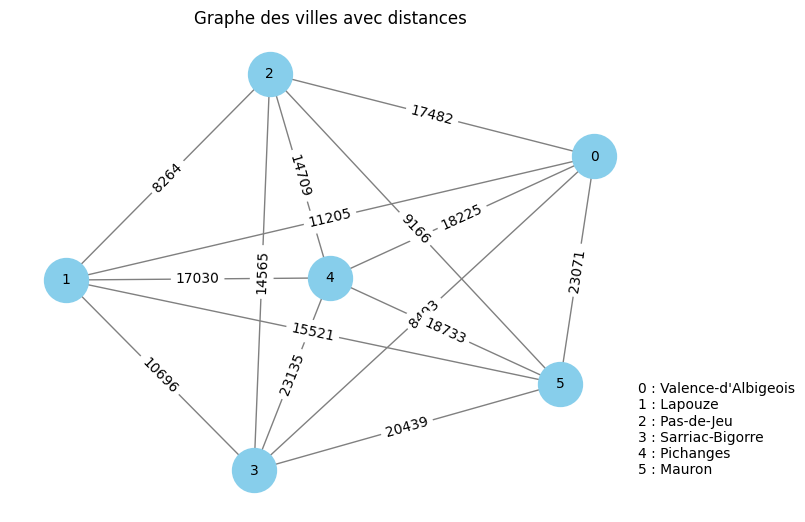

In [20]:
### Generate graph ###
def generate_complete_graph(matrix, cities):
    import networkx as nx
    import matplotlib.pyplot as plt
    
    G = nx.Graph()
    cities_converted = {}
    index = -1

    for city1 in range(len(cities)):
        for city2 in range(len(cities)):
            if city1 != city2:
                if matrix[city1][city2][1] != None:
                    if city1 not in cities_converted: 
                        index+=1
                        cities_converted[city1] = index
                    if city2 not in cities_converted:
                        index+=1
                        cities_converted[city2] = index
                    G.add_edge(cities_converted[city1], cities_converted[city2], weight=f"{matrix[city1][city2][1]}")
            
    pos = nx.spring_layout(G, seed=12, k=1.5)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Graphe des villes avec distances")
    i = 0
    plt.text(1, -1, "\n".join([f"{i} : {city}" for i, city in enumerate(cities.keys())]), fontsize=10)
    plt.show()

def generate_hamiltonian_graph(path, path_cost, matrix, cities):
    import networkx as nx
    import matplotlib.pyplot as plt
    
    G = nx.DiGraph()
    cities_converted = {}
    total_weight = 0

    for city_index in range(len(path) - 1):
        city1 = list(cities.items())[path[city_index]]    
        city2 = list(cities.items())[path[city_index+1]]
        if city1 != city2:
            if city1 not in cities_converted: 
                cities_converted[city1] = path[city_index]
            if city2 not in cities_converted:
                cities_converted[city2] = path[city_index+1]

            edge_weight = matrix[list(cities.keys()).index(city1[0])][list(cities.keys()).index(city2[0])][1]
            total_weight += edge_weight
            G.add_edge(cities_converted[city1], cities_converted[city2],weight=f"{edge_weight}")
    
    if path_cost != total_weight:
        raise "Dissociation between given path cost and computed total weight"
    
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', font_size=10)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray', width=2, alpha=0.7, arrowstyle='-|>', arrowsize=20)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title("Graphe du chemin à suivre entre les villes")
    plt.text(1, -1, "\n".join([f"{i} : {city}" for i, city in enumerate(cities.keys())]) + f"\n\nCoût du chemin : {path_cost}", fontsize=10)
    plt.show()

def generate_complete_map(cities):
    import folium
    import webbrowser
    from collections import defaultdict
    
    french_map = folium.Map(location=[46.5, 2.5], zoom_start=6)
    loc_cities = defaultdict(list)

    for city in cities:
        lat, lon = Cities[city]
        if (lat or lon) != None:
            loc_cities[city].append((lat, lon))
        else:
            cities.pop(city)

    for city in cities:
        lat, lon = loc_cities[city][0]
        folium.Marker(location=[lat, lon], popup=city).add_to(french_map)

        for destCity in cities:
            if destCity != city:
                dest_lat, dest_lon = loc_cities[destCity][0]
                folium.PolyLine([(lat, lon), (dest_lat, dest_lon)], color="blue", weight=1).add_to(french_map)
    french_map.save("graphe_complet_sur_carte.html")
    webbrowser.open("graphe_complet_sur_carte.html")

def generate_hamiltonian_map(path, cities):
    import folium
    import webbrowser
    from collections import defaultdict

    french_map = folium.Map(location=[46.5, 2.5], zoom_start=6)
    loc_cities = defaultdict(list)

    for city in cities:
        lat, lon = cities[city]
        if lat and lon:
            loc_cities[city].append((lat, lon))
        else:
            cities.pop(city)

    for i, city in enumerate(cities):
        lat, lon = loc_cities[city][0]
        folium.Marker(
            location=[lat, lon],
            popup=city,
            icon=folium.DivIcon(html=f"""<div style="font-size: 16pt; color: white; background-color: blue; border-radius: 50%; width: 24px; height: 24px; text-align: center; line-height: 24px;">{i}</div>""")
        ).add_to(french_map)

    for i in range(len(path) - 1):
        city1 = list(cities.keys())[path[i]]  
        city2 = list(cities.keys())[path[i + 1]] 
        
        lat1, lon1 = loc_cities[city1][0]
        lat2, lon2 = loc_cities[city2][0]

        folium.PolyLine([(lat1, lon1), (lat2, lon2)], color="blue", weight=2, opacity=0.6).add_to(french_map)

    french_map.save("graphe_hamiltonien_sur_carte.html")
    webbrowser.open("graphe_hamiltonien_sur_carte.html")
    
generate_complete_graph(printable_matrix, Cities)
generate_complete_map(Cities)


##### 2.2. Justification du maintien de la modélisation
Après vérification, aucune modification n’a donc été nécessaire dans la structure mathématique pour répondre aux objectifs du projet. Nous avons décidé de conserver la structure et les représentations formelles définies dans le livrable précédent.

Cette modélisation s'est révélée suffisamment expressive pour prendre en compte l'ensemble des contraintes que nous souhaitons intégrer au problème.<br>
De plus, notre problème est basé sur le **problème du voyageur du commerce (TSP)**, bien que nous avons démontré que ce problème est difficile (NP-complet), il est applicable à d'autres problèmes de logistique.


### 3. Méthodes de résolution
##### 3.1. Choix des algorithmes
##### 3.2. Description des algorithmes 
##### 3.2.1. Held-Karp
L'algorithme de Bellman-Held-Kard a  
##### 3.3. Complexité des algorithmes 
| Algorithme | Complexité temporelle | Complexité spatiale |
| ----------- | ----------- | - |
| Held-karp | $O(n^2\cdot2^n)$ | $O(n\cdot2^n)$ |
| Génétique | | |




### 4. Implémentation
##### 4.1. Détails de l’implémentation des algorithmes
##### 4.1.1. Held-Karp

In [15]:
import random
from pyprobs import Probability as pr
import math
# Définition d'une constante pour la valeur maximale
MAX = math.inf  

City_Dependance = []

def generate_city_dependance(cities):
    """
    Generates a city dependence matrix based on the number of cities.
    """
    city_dependance = []
    for i in range(len(cities)):
        submatrix = []
        for j in range(len(cities)):
            if i == j:
                submatrix.append(0)
            else:
                road_blocked = pr.prob(0.25)  # 5% de probabilité
                if road_blocked:
                    submatrix.append(0)
                else:
                    submatrix.append(1)
        city_dependance.append(submatrix)
    return city_dependance
City_Dependance = generate_city_dependance(Cities)

def generate_ponderation_matrix(matrix):
    ponderation_matrix = []

    for i in range(len(matrix)):
        submatrix = []
        for j in range(len(matrix[i])):
            road_blocked = pr.prob(0.05)# 5% de probabilité
            road_cost = random.uniform(0.6, 1.4)

            if road_blocked or matrix[i][j][0] == 0:
                submatrix.append(MAX)
            else:
                distance = matrix[i][j][0]
                time = matrix[i][j][1]
                cost = int(distance * 0.7) + int(time * 0.5 * road_cost)
                submatrix.append(cost)

        ponderation_matrix.append(submatrix)

    return ponderation_matrix

ponderation_matrix = generate_ponderation_matrix(matrix)
def calcul_fitness(chemin, matrice_ponderation, City_Dependance ):
    """
    Calcule la distance totale d'un chemin donné dans la matrice de distances.
    """
    ponderation_totale = 0
    for i in range(len(chemin) - 1):
        
        if matrice_ponderation[chemin[i]][chemin[i + 1]] == MAX:
            return float('inf')
        if City_Dependance[chemin[i]][chemin[i + 1]] == 0:
            return float('inf')
        if City_Dependance[chemin[i]][chemin[i + 1]] == 1:
            ponderation_totale += matrice_ponderation[chemin[i]][chemin[i + 1]]
    return ponderation_totale

In [ ]:
### Convert ponderation to fit with held-karp
def convert_matrix(matrix, ponderation_matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            matrix[i][j][1] = ponderation_matrix[i][j]

    return matrix

converted_matrix = convert_matrix(printable_matrix, ponderation_matrix)
print(converted_matrix)

[[[0, inf], ['04:23:59', inf], ['06:46:06', 17450], ['03:19:23', 8479], ['07:01:30', 18113], ['09:02:15', 23348]], [['04:23:38', 11205], [0, inf], ['03:14:02', inf], ['04:13:39', 10773], ['06:34:26', 16902], ['06:03:21', 15511]], [['06:47:16', 17482], ['03:13:29', 8264], [0, inf], ['05:40:47', 14471], ['05:42:11', 14678], ['03:37:17', 9231]], [['03:18:31', 8493], ['04:12:12', 10696], ['05:39:11', 14565], [0, inf], ['09:01:54', 23155], ['07:55:21', 20374]], [['07:04:08', 18225], ['06:38:03', 17030], ['05:43:23', 14709], ['09:04:43', 23135], [0, inf], ['07:16:32', 18656]], [['09:02:58', 23071], ['06:03:03', 15521], ['03:35:25', 9166], ['07:56:30', 20439], ['07:15:45', 18733], [0, inf]]]


In [17]:
import itertools
from tqdm import tqdm
def held_karp(dist, dependance_matrix ,start=0):
    
    n = len(dist)
    C = {}

    for k in tqdm(range(n)):
        if k == start:
            continue
        C[(frozenset([start, k]), k)] = (dist[start][k][1], [start, k])

    for subset_size in tqdm(range(2, n)):
        for subset in tqdm(itertools.combinations([i for i in range(n) if i != start], subset_size)):
            S = frozenset((start,) + subset)
            for j in subset:
                prev_subset = S - {j}
                min_cost = float('inf')
                min_path = []

                for k in subset:
                    if k == j or dependance_matrix[j][k] != 1:
                        continue
                    prev_cost, prev_path = C.get((prev_subset, k), (float('inf'), []))
                    cost = prev_cost + dist[k][j][1]
                    if cost < min_cost:
                        min_cost = cost
                        min_path = prev_path + [j]

                C[(S, j)] = (min_cost, min_path)

    full_set = frozenset(range(n))
    min_cost = float('inf')
    min_path = []

    for k in tqdm(range(n)):
        if k == start:
            continue
        cost, path = C[(full_set, k)]
        total_cost = cost + dist[k][start][1]
        if total_cost < min_cost:
            min_cost = total_cost
            min_path = path + [start]

    return min_cost, min_path

min_cost, path = held_karp(converted_matrix, start=0)
print(f"Coût minimum : {min_cost}\nChemin : {path}")
generate_hamiltonian_graph(path, min_cost, converted_matrix, Cities)
generate_hamiltonian_map(path, Cities)

TypeError: held_karp() missing 1 required positional argument: 'dependance_matrix'

##### 4.1.2. Algorithme génétique

In [ ]:
# mise en place algorith genetique 
import math 
def generate_initial_population(size, num_cities):
    population = []
    for _ in range(size):
        path = list(range(num_cities))
        random.shuffle(path)
        population.append(path)
    return population


def selection(population, fitnesses):
    sorted_pop = [p for _, p in sorted(zip(fitnesses, population), key=lambda x: x[0])]
    return sorted_pop[:2]

def crossover(parent1, parent2):
    size = len(parent1)
    start = random.randint(0, size - 2)
    end = random.randint(start + 1, size - 1)
    child = [-1]*size
    child[start:end] = parent1[start:end]
    fill = [c for c in parent2 if c not in child]
    j = 0
    for i in range(size):
        if child[i] == -1:
            child[i] = fill[j]
            j += 1
    return child

def mutate(path, temperature):
    # Recuit simulé : petite proba d'accepter une mauvaise mutation
    i, j = random.sample(range(len(path)), 2)
    new_path = path[:]
    new_path[i], new_path[j] = new_path[j], new_path[i]
    return new_path

def should_accept(current_fitness, new_fitness, temperature):
    if new_fitness < current_fitness:
        return True
    delta = new_fitness - current_fitness
    prob = math.exp(-delta / temperature) if temperature > 0 else 0
    return random.random() < prob

def genetic_with_annealing(matrix, City_Dependance, population_size=50, generations=100, initial_temp=100, cooling_rate=0.95):
    num_cities = len(matrix)
    population = generate_initial_population(population_size, num_cities)
    temperature = initial_temp

    best_solution = None
    best_fitness = MAX

    for generation in range(generations):
        fitnesses = []
        for path in population:
            fitness = calcul_fitness(path, matrix, City_Dependance)
            fitnesses.append(fitness)

        # Prune les chemins inf pour améliorer les perfs
        valid_population = [p for p, f in zip(population, fitnesses) if f != MAX]
        valid_fitnesses = [f for f in fitnesses if f != MAX]

        if not valid_population:
            print(f"Gen {generation}: aucune solution valide.")
            population = generate_initial_population(population_size, num_cities)
            continue

        best_idx = valid_fitnesses.index(min(valid_fitnesses))
        if valid_fitnesses[best_idx] < best_fitness:
            best_solution = valid_population[best_idx]
            best_fitness = valid_fitnesses[best_idx]

        next_gen = []
        while len(next_gen) < population_size:
            parents = selection(valid_population, valid_fitnesses)
            child = crossover(parents[0], parents[1])
            mutated = mutate(child, temperature)

            current_fitness = calcul_fitness(child, matrix, City_Dependance)
            new_fitness = calcul_fitness(mutated, matrix, City_Dependance)

            if should_accept(current_fitness, new_fitness, temperature):
                next_gen.append(mutated)
            else:
                next_gen.append(child)

        population = next_gen
        temperature *= cooling_rate
        print(f"Gen {generation}: Best Fitness = {best_fitness:.2f}, Temp = {temperature:.2f}")

    return best_solution, best_fitness

best_solution, best_fitness = genetic_with_annealing(ponderation_matrix, City_Dependance, population_size=500, generations=100, initial_temp=100, cooling_rate=0.98)
print("Best solution:", best_solution)
print("Best fitness:", best_fitness)


##### 4.2. Cas de test représentatifs
##### 4.3. Résultats observés sur les tests


### 5. Étude expérimentale
##### 5.1. Méthodologie du plan d’expérience
##### 5.2. Analyse des performances 
##### 5.3. Limites observées
##### 5.4. Perspectives d’amélioration



### 6. Plan de Travail et Organisation du Projet
##### 6.1. Étapes prévues 


### 7. Conclusion


### 8. Annexes
##### 8.1. Glossaire
##### 8.2. Références bibliographiques
##### 8.3. Annexes techniques 